# Antecedentes

<p align = "justify">Se importó la base del Registro Nacional de Personas Desaparecidas y No Localizadas (RNPDNO), desde el portal: https://versionpublicarnpdno.segob.gob.mx/Dashboard/Index. Esta está compuesta por 20 archivos en formato json, cuyo peso conjunto es 3.09GB y consta de 113,303 documentos, el número de campos en cada documento es variable y consolida en un solo repositorio la información de 72 instituciones de todo México.</p>

<p align = "justify">Los 20 archivos con 113,303 documentos fueron procesados a través de un programa diseñado en Python para leer la información de los archivos json, manejar las excepciones que pueda generar la variabilidad en los pares clave valor y llevarlos a una base de datos SQL, bajo un formato de tabla que pueda ser más adecuado para realizar un data cleaning, un análisis descriptivo de las variables y en general que facilite el proceso de KDD. Con este desarrollo, se llegó a recuperar el 99.5% (112,767 registros) de los documentos contenidos en los archivos json.</p>

# Limpieza y Transformación Inicial de Datos en la Base de Datos

La data inicial extraída consta de 112,767 registros con 37 columnas, todas en formato String. Sobre la base de datos se realizó las siguientes acciones:

## 1.   Limpieza
*   Se reemplazó todos los registros que indicaban "Sin Dato" o "Eliminado" o similares, por Null.
*   Sobre el campo "Fecha de Inicio de Expediente", las fechas por debajo de 1900 se reemplazaron con Null.
*   Sobre el campo "Fecha de Nacimiento", las fechas por debajo de 1899 se reemplazaron con Null.
*   Sobre el campo "Fecha de Nacimiento", las fechas por debajo de 1899 se reemplazaron con Null.
*   Sobre los campos "Estado de los Hechos" y "Lugar de Nacimiento" se reemplazo el valor de "Estado de México" por "México", que es el nombre oficial. Esto servirá para poder cruzar esta información con otras fuentes, como la data del censo 2020 del INEGI.
*   Sobre el campo "Status de la víctima", se unifica los valores "Desaparecida" y "Desaparecida/No localizada" en un solo valor: "No localizada".


## 2.   Transformación de columnas

*   Se casteo todas las fechas de String a Date
*   En base al campo "Institución que reporta", se extrae el estado al que pertenece la institución en caso se especifíque. El que se utilizará para completar el campo "Estado de los Hechos" en caso venga vacío.
*   En base al campo "Institución que reporta", se extrae el tipo de institución que reporta la desaparición, pudiendo ser por ejemplo: la fiscalía general de un estado, la comisión nacional o local de búsqueda, la fiscalía general de la república, procuradorías o subprocuradorías, el portal web, etc. Se rescataron 8 tipos de instituciones distintas.


## 3.   Unificación de columnas

*   En caso hayan dos instituciones hayan reportado la desaparición, cada uno de los siguientes campos está contenido en dos campos distintos: institución que reporta la desaparición, status de la víctima, fecha de inicio de expediente, hipótesis de la desaparición, delito, sexo/género, fecha de los hechos, fecha que se percata de la desaparición, lugar (estado, municipio y colonia) de los hechos.
Se unificó un solo campo para cada item arriba descrito, bajo el criterio de en caso los datos de la primera insitución vengan vacíos rescatar la mayor cantidad de información posible, así mismo si una de las instituciones era el portal web y la otra una institución física, se priorizo como "Institución que reporta la desaparición" a la institución física.
*   Se unifica en el campo "Fecha de los hechos", los campos "Fecha de los hechos" y "Fecha en la que se percata de la desaparición", priorizando la información contenida en el primero y en caso este venga vacío, se toma la información del segundo cuando contenga un valor.
*   Se unifica los campos "Sexo" y "Género" en un solo campo llamado "Sexo", priorizando la información existente en el campo "Sexo". Esto después de muestrear la información contenida en los archivos y validar contra el nombre (si es un nombre de mujer u hombre), que el campo "Sexo" es el más fiable en caso hubiere una diferencia contra lo indicado en "Género".


## 4.   Complemento de Información

*   Se calcula el campo "Edad Alterna" que es la diferencia entre la "Fecha de Nacimiento" y la "Fecha de los Hechos" (unificado). Este campo permite saber la edad al momento de la ocurrencia del hecho y servirá para validar el campo "Edad" existente y rescatar la información de la edad en caso el campo anterior venga vacío.
*   Se realiza el proceso inverso para en base a los campos "Fecha de Nacimiento", "Edad en Años", "Edad en Meses" y "Edad en días", para poder deducir el campo "Fecha de los hechos", sumando a la "Fecha de nacimiento" la edad en años, meses y días. Esto servirá para validar el campo "Fecha de los hechos" existente y rescatar la información de la edad en caso el campo anterior venga vacío.
*   Se complementa el campo "Fecha de los hechos" con el campo "Fecha de inicio del expediente", en caso el primero venga vacío se toma el valor del segundo, siempre que no sea Null.


## 5.   Enriquecimiento de la información

Se complementó la información del estado y municipio de los hechos con la información del Censo 2020 efectuado por el INEGI, para ello se cargó 300,690 registros de información relacionada a MySQL, el nivel de granularidad del Censo es hasta la localidad de cada municipio. Sin embargo, se agrupó la data por municipio para que conversé mejor con la data que con se cuenta proveniente del RNPDNO, la cual tiene muy poca data en el campo "Localidad de los Hechos" y mayor cantidad de data en los campos "Estado de los Hechos" y "Municipio de los Hechos".
Para hacer esto, se homogenizó los nombres de los estados y municipios a los oficiales según los Estados Unidos Mexicanos y se corrigió inconsistencias entre estados y municipios que no guardaban relación. Con lo cual se rescató el 100% de la información relacionada a estados y municipios de ocurrencia de los hechos y esto permitió traer los siguientes datos del censo:
*   Nombre estándar del estado de los hechos
*   Nombre estándar del municipio de los hechos
*   Clave geográfica del estado/municipio de los hechos
*   Población
*   Población de hombres
*   Población de mujeres
*   Nro. de viviendas.
*   Altura sobre el nivel del mar

La clave geográfica permitirá georeferenciar en un mapa los diferentes datos relacionados a la desparición de personas para todos los estados.

# Trabajo de la Información en Python

## Carga del Dataset en un Data Frame

In [ ]:
# Ejecutar siempre primero esto, carga de librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime
import requests
import geopandas as gpd
import plotly.express as px
plt.rcParams.update({'font.size': 11})

In [ ]:
# Lee el archivo CSV
df_inicial = pd.read_csv("RNPDNO.csv")
df_regiones = pd.read_csv("regiones.csv")
df_tipo_reporte = pd.read_csv("tipo de reporte.csv")
df_institucion_tipo = pd.read_csv("Institucion Tipo.csv")

df_inicial = pd.merge(df_inicial, df_regiones, on='HECHOS_ESTADO_NOMBRE', how='left')
df_inicial = pd.merge(df_inicial, df_tipo_reporte, on='TIPO_REPORTE', how='left')
df_inicial = pd.merge(df_inicial, df_institucion_tipo, on='INSTITUCION_TIPO', how='left')

# Borra columnas no necesarias o redundantes que provienen del procesamiento en la base de datos.
df_inicial.drop(columns = ['LUGAR_NACIMIENTO',
                          'LUGAR_NACIMIENTO_ID',
                          'HECHOS_MUNICIPIO',
                          'HECHOS_MUNICIPIO_ID',
                          'HECHOS_ESTADO',
                          'HECHOS_ESTADO_ID'], inplace = True)
df_inicial.shape

(112767, 26)

Se cargaron 112,767 registros y 22 atrbiutos.

## Detección de Valores Faltantes

In [ ]:
# Cuantificaremos los valores faltantes
datos = df_inicial
total = datos.isnull().sum().sort_values(ascending = False)
porcentaje_nulos = (datos.isnull().sum() / datos.isnull().count().sort_values(ascending = False))
datos_faltantes = pd.concat([total, porcentaje_nulos], axis = 1, keys = ['Total','Porcentaje'])
datos_faltantes_format = pd.concat([total.apply('{:,.0f}'.format), porcentaje_nulos.apply('{:,.1%}'.format)], axis = 1, keys = ['Valores Faltantes','Porcentaje del Total'])
print('-------------------------------------',
      'Los Valores Faltantes del Dataset son :',
      total.apply('{:,.0f}'.format),
      '\nEl % de Valores Faltantes del Dataset: ',
      datos_faltantes_format[datos_faltantes['Total']>0], sep = '\n')

-------------------------------------
Los Valores Faltantes del Dataset son :
LUGAR_NACIMIENTO_NOMBRE      94,083
DELITO                       93,585
EST_CIVIL                    93,266
HIPOTESIS                    75,480
FECHA_NACIMIENTO             69,272
HECHOS_MUNICIPIO_NOMBRE      39,695
EDAD                         37,047
HECHOS_FECHA                 35,455
NACIONALIDAD                 32,710
SEXO                         32,708
INSTITUCION_ESTADO           13,315
ALTITUD                       5,339
POBLACION_H                   5,339
POBLACION_M                   5,339
VIVIENDAS                     5,339
POBLACION                     5,339
HECHOS_ESTADO_NOMBRE          5,339
HECHOS_CLAVE_GEO              5,339
REGION                        5,339
INSTITUCION_TIPO                  0
STATUS_VICTIMA                    0
NRO_REPORTE                       0
CONSECUTIVO                       0
TIPO_REPORTE                      0
ETIQUETA_TIPO_REPORTE             0
ETIQUETA_INSTITUCION_T

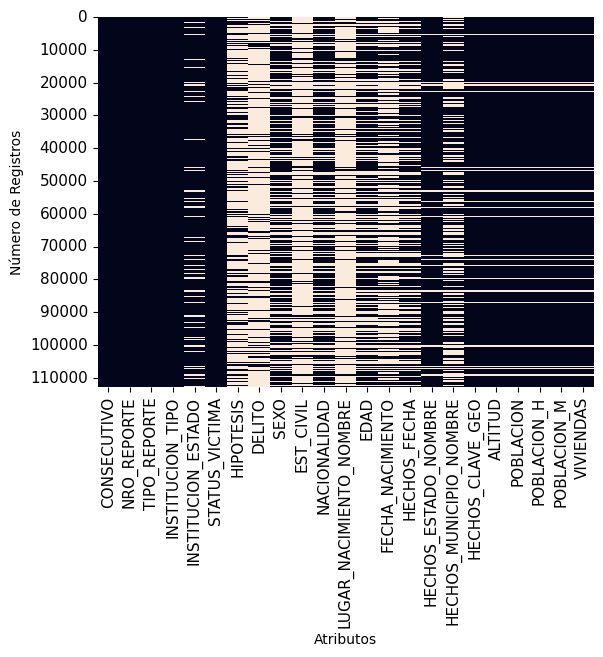

In [ ]:
# Graficaremos los valores faltantes
ax = plt.axes()
etiqueta_y = np.arange(0, 112767, 10000)
sns.heatmap(df_inicial.iloc[:, :-3].isnull(), cbar=False, ax=ax, yticklabels = np.arange(0, 112767, 10000))
plt.yticks(etiqueta_y,etiqueta_y)
plt.xlabel("Atributos", fontsize = 10)
plt.ylabel("Número de Registros", fontsize = 10)
plt.show()

Se puede observar tanto cuantitativamente como visualmente que los 3 atributos con más del 66% de sus valores como faltantes son, en orden: lugar de nacimiento, delito, estado civil e hipótesis.

## Descripción de Atributos

### Atributo: "CONSECUTIVO"

El atributo "Consecutivo" es el ID de cada de registro, algunas personas han sido reportadas desaparecidas más de una vez, por lo que un "Consecutivo" puede tener entre 1 y 2 números de reporte.

In [ ]:
print(f"Recuento: {df_inicial['CONSECUTIVO'].count()}")
print(f"Valor mínimo: {df_inicial['CONSECUTIVO'].min()}")
print(f"Valor máximo: {df_inicial['CONSECUTIVO'].max()}")

Recuento: 112767
Valor mínimo: 1
Valor máximo: 110772


### Atributo: "NRO_REPORTE"

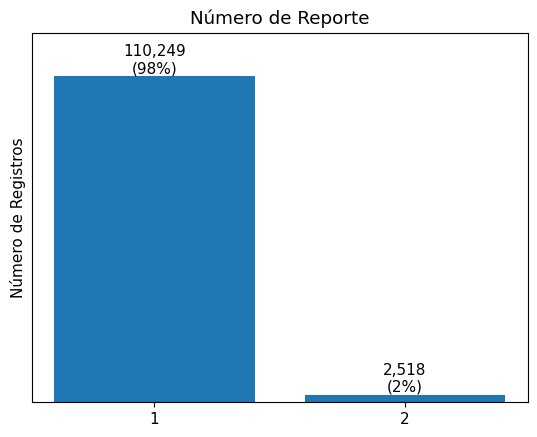

In [ ]:
df_agrupado = df_inicial[['NRO_REPORTE','CONSECUTIVO']].groupby('NRO_REPORTE').count().reset_index()

eje_x = df_agrupado['NRO_REPORTE'].astype(str)
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.set(ylabel='Número de Registros', title='Número de Reporte', ylim=(0, 125000), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()

### Atributo: "TIPO_REPORTE"

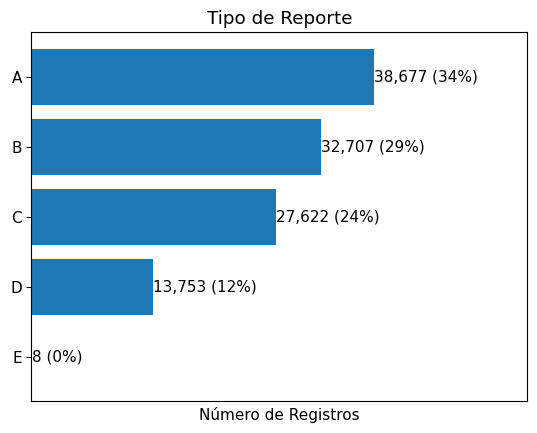

In [ ]:
df_agrupado = df_inicial[['ETIQUETA_TIPO_REPORTE','CONSECUTIVO']].groupby('ETIQUETA_TIPO_REPORTE').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['ETIQUETA_TIPO_REPORTE']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]


fig, ax = plt.subplots()
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Número de Registros', title='Tipo de Reporte', xlim=(0, 56000), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()

### Atributo: "INSTITUCION_TIPO"

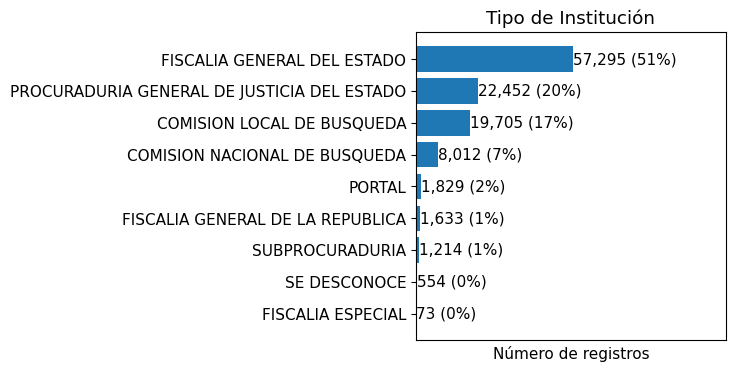

In [ ]:
df_agrupado = df_inicial[['INSTITUCION_TIPO','CONSECUTIVO']].groupby('INSTITUCION_TIPO').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['INSTITUCION_TIPO']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(4)
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Número de registros', title='Tipo de Institución', xlim=(0, 112767), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x')
plt.show()


### Atributo: "INSTITUCION_ESTADO"

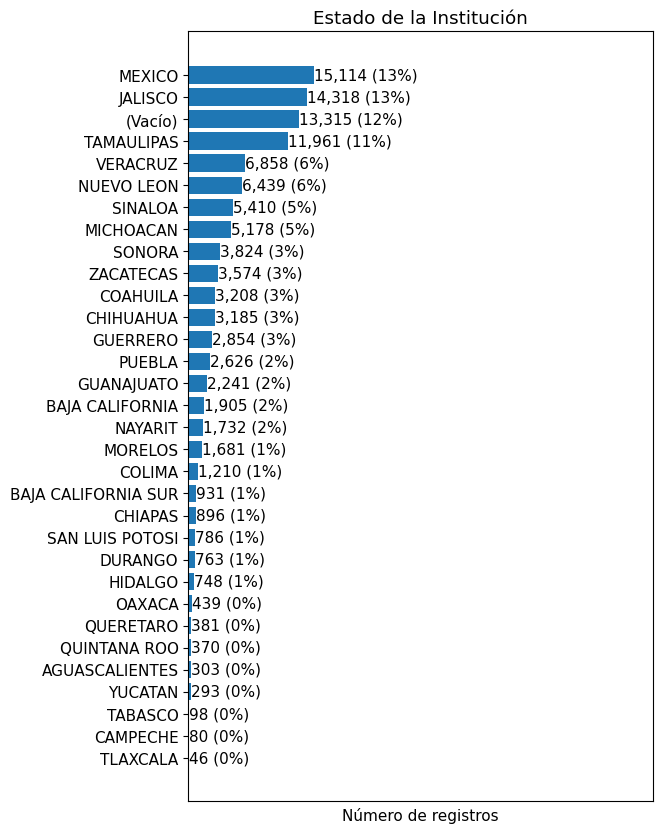

In [ ]:
df_agrupado = df_inicial[['INSTITUCION_ESTADO','CONSECUTIVO']].replace({'INSTITUCION_ESTADO': {np.nan: '(Vacío)'}}).groupby('INSTITUCION_ESTADO').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['INSTITUCION_ESTADO']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(6)
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Número de registros', title='Estado de la Institución', xlim=(0, 56000), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x', rotation=90)
plt.show()


### Atributo: "STATUS_VICTIMA"

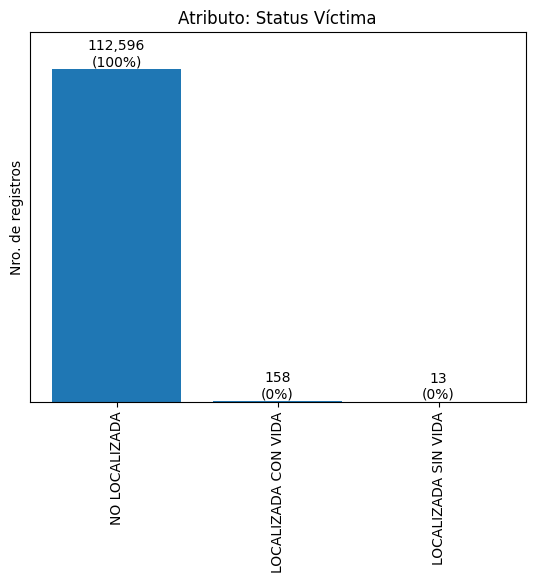

In [ ]:
df_agrupado = df_inicial[['STATUS_VICTIMA','CONSECUTIVO']].replace({'STATUS_VICTIMA': {np.nan: '(Vacío)'}}).groupby('STATUS_VICTIMA').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=False, inplace=True)

eje_x = df_agrupado['STATUS_VICTIMA']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(ylabel='Nro. de registros', title='Atributo: Status Víctima', ylim=(0, 125000), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x', rotation=90)
plt.show()

### Atributo: "HIPOTESIS"

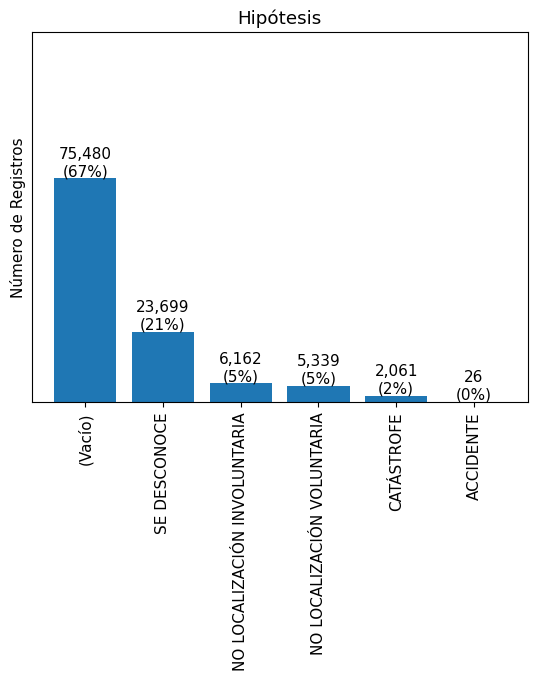

In [ ]:
df_agrupado = df_inicial[['HIPOTESIS','CONSECUTIVO']].replace({'HIPOTESIS': {np.nan: '(Vacío)'}}).groupby('HIPOTESIS').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=False, inplace=True)

eje_x = df_agrupado['HIPOTESIS']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(ylabel='Número de Registros', title='Hipótesis', ylim=(0, 125000), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x', rotation=90)
plt.show()

Si en la composición del atributo, no tomamos en cuenta los valores vacíos:

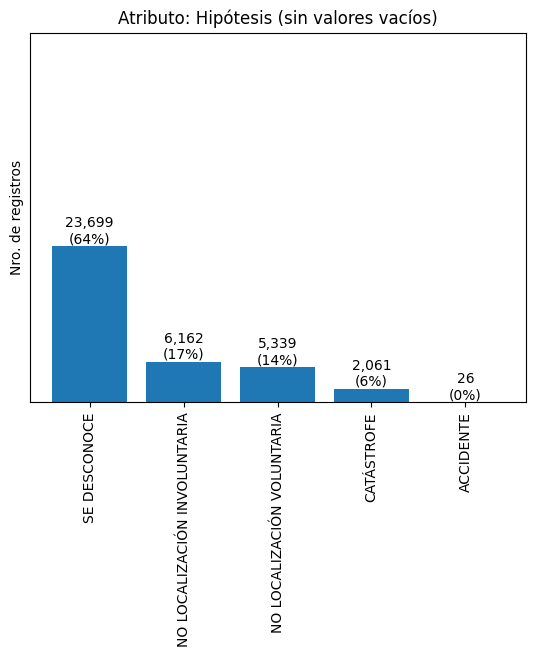

In [ ]:
df_agrupado = df_inicial[['HIPOTESIS','CONSECUTIVO']].groupby('HIPOTESIS').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=False, inplace=True)

eje_x = df_agrupado['HIPOTESIS']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(ylabel='Nro. de registros', title='Atributo: Hipótesis (sin valores vacíos)', ylim=(0, 56000), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x', rotation=90)
plt.show()

### Atributo: "DELITO"

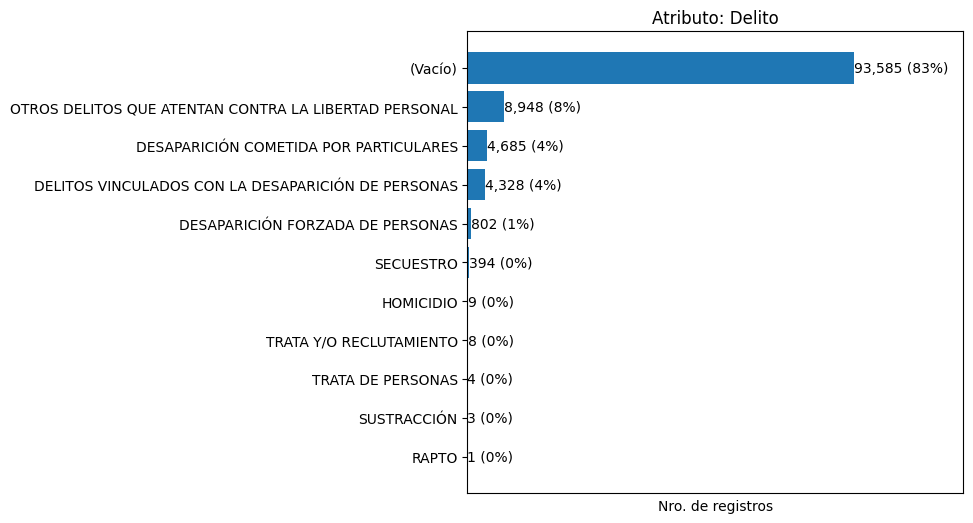

In [ ]:
df_agrupado = df_inicial[['DELITO','CONSECUTIVO']].replace({'DELITO': {np.nan: '(Vacío)'}}).groupby('DELITO').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['DELITO']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
fig.set_figheight(6)
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Nro. de registros', title='Atributo: Delito', xlim=(0, 120000), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()

Si en la composición del atributo, no tomamos en cuenta los valores vacíos:

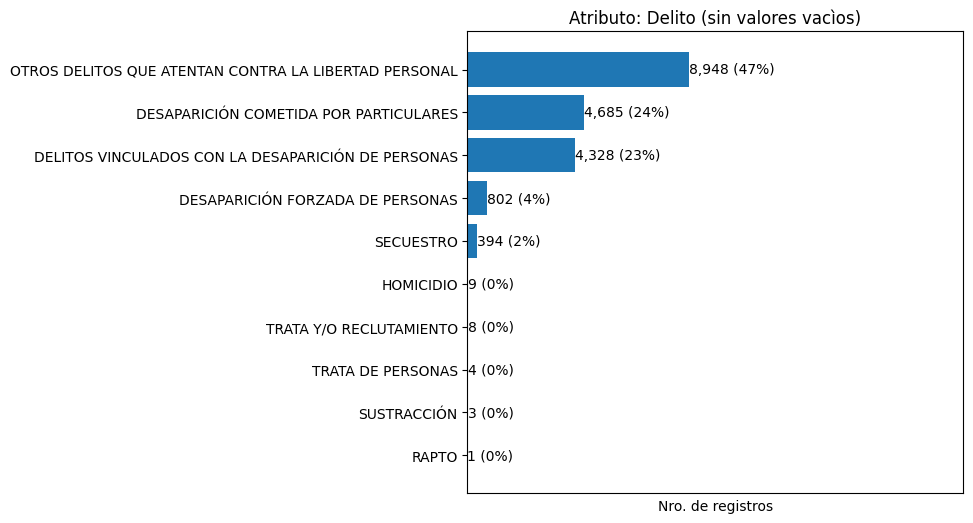

In [ ]:
df_agrupado = df_inicial[['DELITO','CONSECUTIVO']].groupby('DELITO').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['DELITO']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
fig.set_figheight(6)
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Nro. de registros', title='Atributo: Delito (sin valores vacìos)', xlim=(0, 20000), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()

### Atributo: "SEXO"

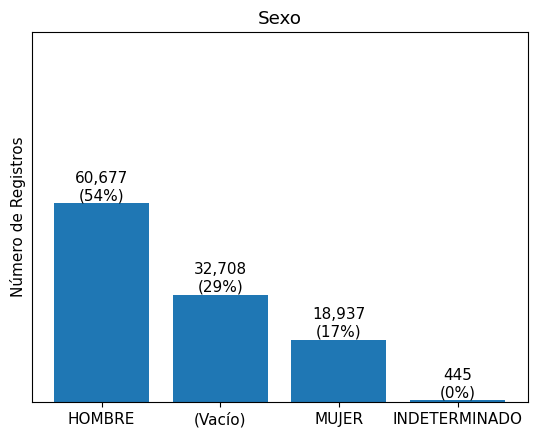

In [ ]:
df_agrupado = df_inicial[['SEXO','CONSECUTIVO']].replace({'SEXO': {np.nan: '(Vacío)'}}).groupby('SEXO').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=False, inplace=True)

eje_x = df_agrupado['SEXO']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(ylabel='Número de Registros', title='Sexo', ylim=(0, 112767), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()

Si en la composición del atributo, no tomamos en cuenta los valores vacíos:

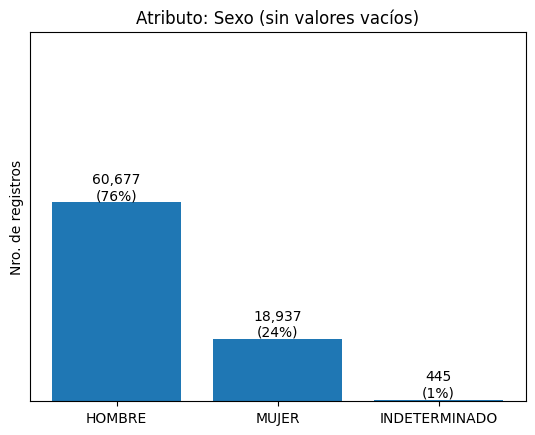

In [ ]:
df_agrupado = df_inicial[['SEXO','CONSECUTIVO']].groupby('SEXO').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=False, inplace=True)

eje_x = df_agrupado['SEXO']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(ylabel='Nro. de registros', title='Atributo: Sexo (sin valores vacíos)', ylim=(0, 112767), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()

### Atributo: "EST_CIVIL"

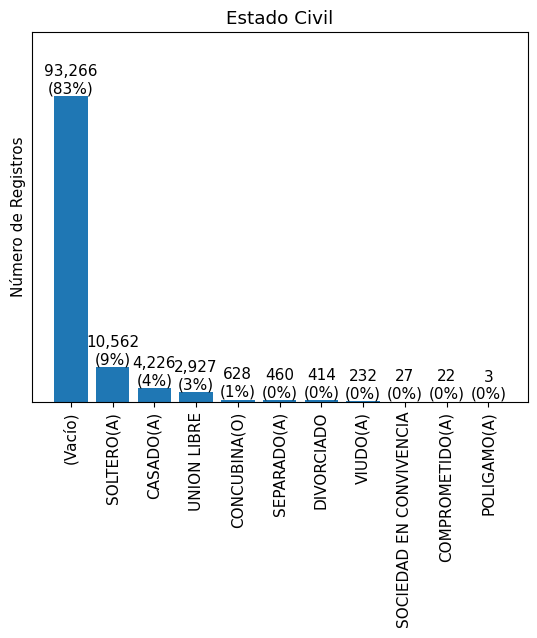

In [ ]:
df_agrupado = df_inicial[['EST_CIVIL','CONSECUTIVO']].replace({'EST_CIVIL': {np.nan: '(Vacío)'}}).groupby('EST_CIVIL').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=False, inplace=True)

eje_x = df_agrupado['EST_CIVIL']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(ylabel='Número de Registros', title='Estado Civil', ylim=(0, 112767), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x', rotation=90)
plt.show()

Si en la composición del atributo, no tomamos en cuenta los valores vacíos:

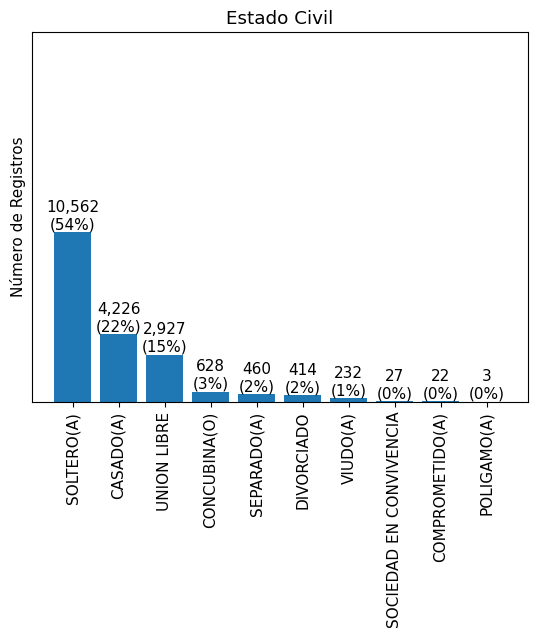

In [ ]:
df_agrupado = df_inicial[['EST_CIVIL','CONSECUTIVO']].groupby('EST_CIVIL').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=False, inplace=True)

eje_x = df_agrupado['EST_CIVIL']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + '\n('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
bar_container = ax.bar(eje_x, eje_y)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(ylabel='Número de Registros', title='Estado Civil', ylim=(0, 23000), yticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x', rotation=90)
plt.show()

### Atributo: "NACIONALIDAD"

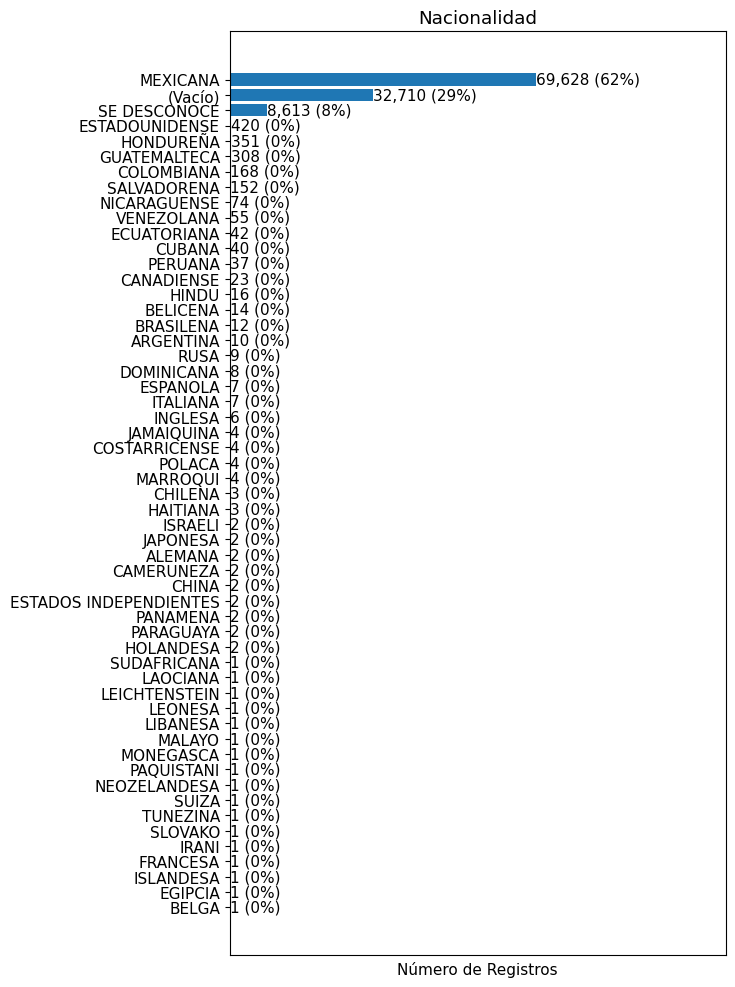

In [ ]:
df_agrupado = df_inicial[['NACIONALIDAD','CONSECUTIVO']].replace({'NACIONALIDAD': {np.nan: '(Vacío)'}}).groupby('NACIONALIDAD').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['NACIONALIDAD']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
fig.set_figheight(12)
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Número de Registros', title='Nacionalidad', xlim=(0, 112767), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()

### Atributo: "LUGAR_NACIMIENTO_NOMBRE"


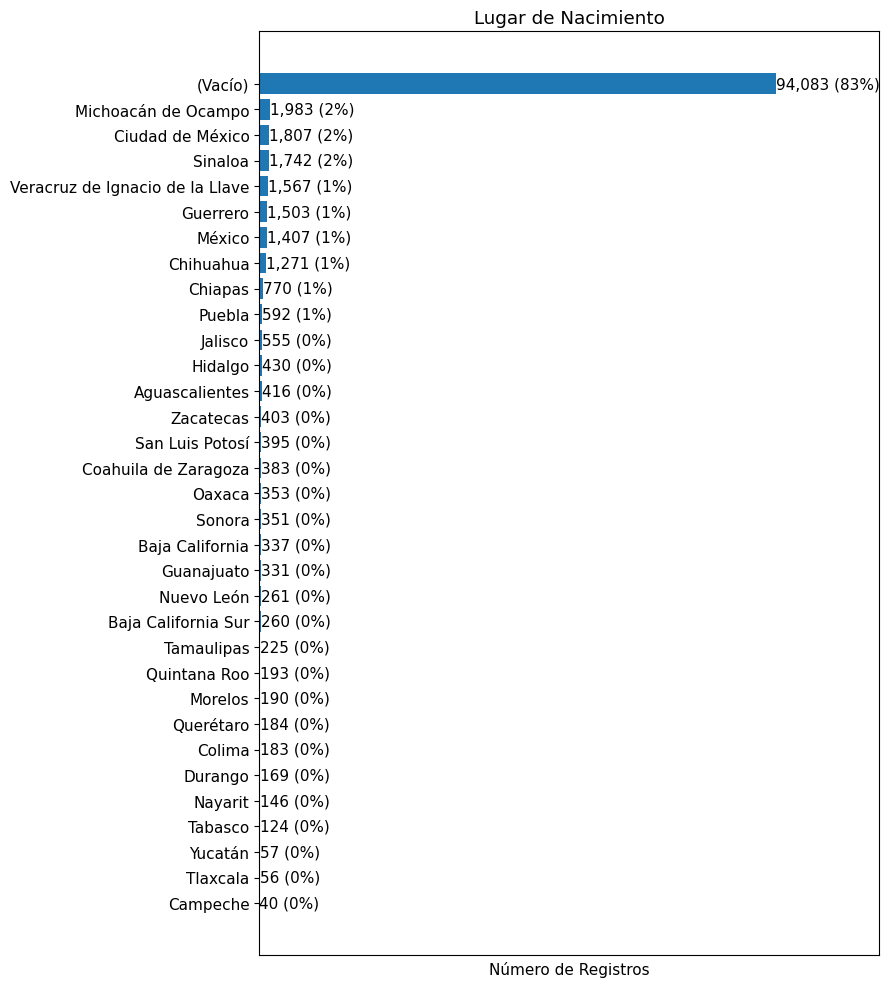

In [ ]:
df_agrupado = df_inicial[['LUGAR_NACIMIENTO_NOMBRE','CONSECUTIVO']].replace({'LUGAR_NACIMIENTO_NOMBRE': {np.nan: '(Vacío)'}}).groupby('LUGAR_NACIMIENTO_NOMBRE').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['LUGAR_NACIMIENTO_NOMBRE']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(8)
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Número de Registros', title='Lugar de Nacimiento', xlim=(0, 112767), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
ax.tick_params(axis='x', rotation=90)
plt.show()


### Atributo: "EDAD"

Descripción del atributo:

In [ ]:
edad = df_inicial['EDAD']
valores_faltantes = df_inicial['EDAD'].isna().sum()
edad.describe().apply('{:,.0f}'.format)

,EDAD
count,"75,720"
mean,31
std,17
min,0
25%,20
50%,29
75%,40
max,"1,832"


In [ ]:
print(f"La cantidad de registros faltantes es: {'{:,.0f}'.format(valores_faltantes)}")

La cantidad de registros faltantes es: 37,047


In [ ]:
porcentaje_0_100 = '{:.2%}'.format(df_inicial.apply(lambda x: x['EDAD'] >= 0 and x['EDAD'] <= 100, axis=1).sum() / df_inicial['EDAD'].count())

print(f"Para el histograma del atributo, se tomarán los valores entre 0 y 100, que del total de registros represantan el: {porcentaje_0_100}")

Para el histograma del atributo, se tomarán los valores entre 0 y 100, que del total de registros represantan el: 99.99%


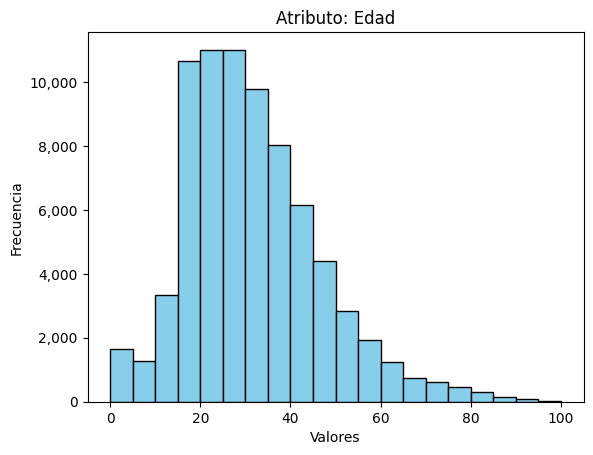

In [ ]:
# Plotting a basic histogram
fig, ax = plt.subplots()
hist_container = ax.hist(edad, bins=20, range=(0,100), color='skyblue', edgecolor='black')

# Adding labels and title
ax.set(xlabel='Valores', ylabel='Frecuencia', title='Atributo: Edad')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Display the plot
plt.show()

####Detección de Outliers:

In [ ]:
df_modif = df_inicial.copy()

edad = df_modif[df_modif['EDAD'].notnull()]['EDAD']

# IQR
# Calculate the upper and lower limits
Q1 = edad.quantile(0.25)
Q3 = edad.quantile(0.75)
IQR = Q3 - Q1
rango_sup = Q3 + 1.5*IQR
rango_inf = Q1 - 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
array_edad_outliers = (df_modif['EDAD'] > rango_sup) | (df_modif['EDAD'] < rango_inf)

df_modif.insert(13, 'EDAD_outliers', array_edad_outliers)
df_modif.insert(14, 'EDAD_modif', df_modif['EDAD'])

min_outlier_edad = int(df_modif[df_modif['EDAD_outliers']]['EDAD'].min())
max_outlier_edad = int(df_modif[df_modif['EDAD_outliers']]['EDAD'].max())
count_outlier_edad = df_modif[df_modif['EDAD_outliers']]['EDAD'].count()

print(f'El atributo edad tiene {count_outlier_edad} registros outliers, cuyos valores inician en: {min_outlier_edad} y termina en: {max_outlier_edad}')

El atributo edad tiene 1511 registros outliers, cuyos valores inician en: 71 y termina en: 1832


####Tratamiento de Outliers:

Para los valores outliers buscaremos volver a calcular la edad restando la fecha de los hechos - la fecha de nacimiento. Si la edad calculada no es un outlier, tomaremos dicho valor como válido:

In [ ]:
df_filter = df_modif[df_modif['EDAD_outliers']]
contador = 0

for i, v in df_filter.iterrows():
  if(not pd.isna(v.HECHOS_FECHA) and not pd.isna(v.FECHA_NACIMIENTO)):
    hoy = datetime.strptime(v.HECHOS_FECHA, '%Y-%m-%d')
    nacimiento = datetime.strptime(v.FECHA_NACIMIENTO, '%Y-%m-%d')
    edad_alterna = hoy.year - nacimiento.year - ((hoy.month, hoy.day) < (nacimiento.month, nacimiento.day))
    if(edad_alterna < v.EDAD and edad_alterna > 0 and edad_alterna <= rango_sup):
      df_modif.loc[i,'EDAD_modif'] = edad_alterna
      contador += 1

print(f'Dejaron de ser outliers {contador} registros.')

Dejaron de ser outliers 4 registros.


Si bien según el método estadístico de IQR para detectar outliers, estos inician a partir de los 71 años, se sabe que una persona como máximo puede vivir hasta los 100 años aprox. Por lo que, solo limpiaremos los valores outliers que estén por encima de los 100 años. El atributo edad que supere este número será llevado a ser NaN

In [ ]:
array_edad_100 = df_modif['EDAD']>100
df_modif.loc[array_edad_100,'EDAD_modif'] = np.nan

print(f'Se actualizaron a NaN: {array_edad_100.sum()} registros.')

Se actualizaron a NaN: 8 registros.


Ahora graficaremos el histograma del atributo edad ya sin outliers:

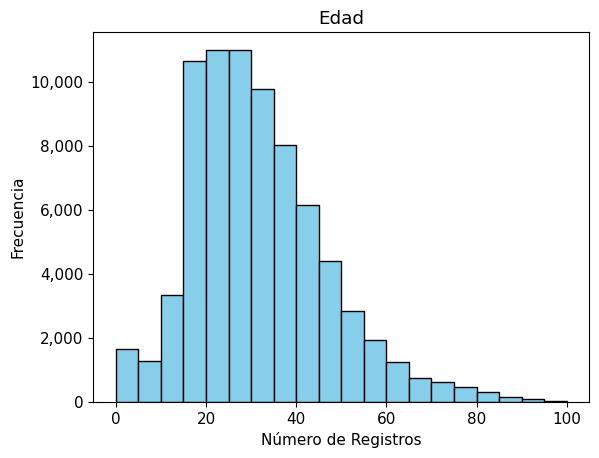

In [ ]:
edad = df_modif['EDAD_modif']

# Plotting a basic histogram
fig, ax = plt.subplots()
hist_container = ax.hist(edad, bins=20, range=(0,100), color='skyblue', edgecolor='black')

# Adding labels and title
ax.set(xlabel='Número de Registros', ylabel='Frecuencia', title='Edad')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Display the plot
plt.show()

### Atributo: "HECHOS_FECHA" (Años)

Descripción del atributo:

In [ ]:
años = pd.to_datetime(df_modif['HECHOS_FECHA'], errors='coerce').dt.year
df_modif['HECHOS_AÑOS'] = años.fillna(-1).astype('int64')
valores_faltantes = df_modif['HECHOS_FECHA'].isna().sum()
años.describe().apply('{:.0f}'.format)

,HECHOS_FECHA
count,77312
mean,2016
std,6
min,1964
25%,2013
50%,2017
75%,2020
max,2024


In [ ]:
print(f"La cantidad de registros faltantes es: {'{:,.0f}'.format(valores_faltantes)}")

La cantidad de registros faltantes es: 35,455


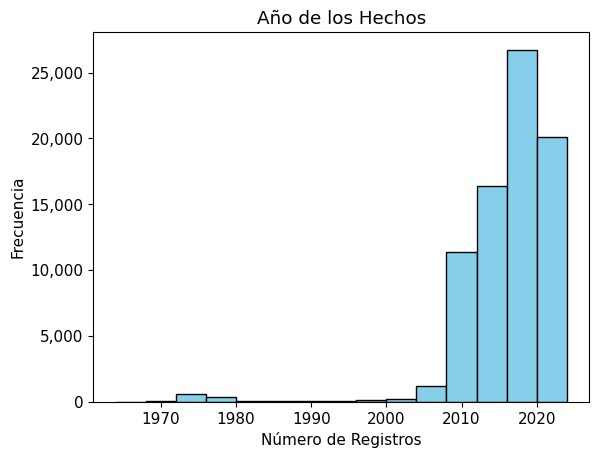

In [ ]:
fig, ax = plt.subplots()
hist_container = ax.hist(años, bins=15, color='skyblue', edgecolor='black')

# Adding labels and title
ax.set(xlabel='Número de Registros', ylabel='Frecuencia', title='Año de los Hechos')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Display the plot
plt.show()

### Atributo: "HECHOS_ESTADO_NOMBRE"

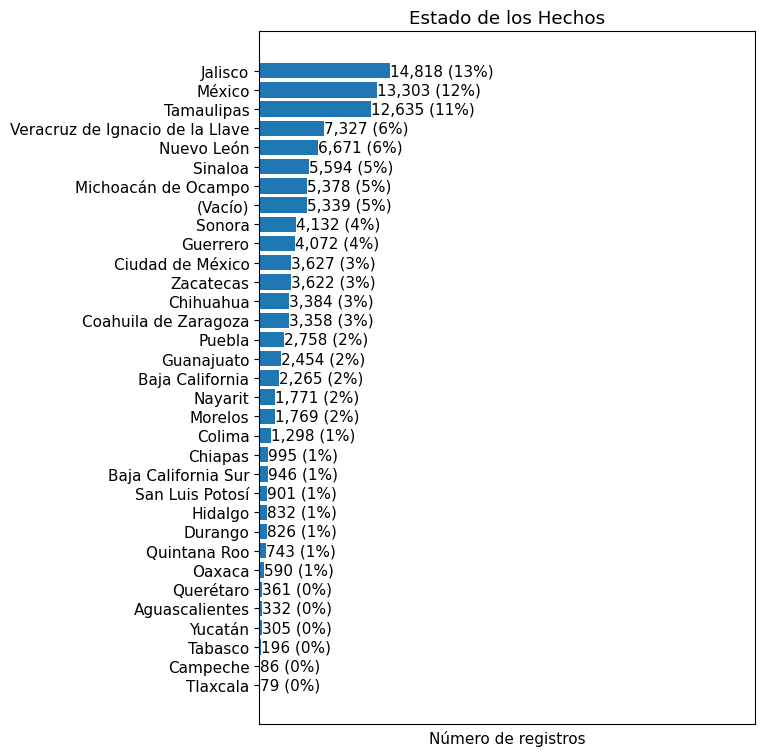

In [ ]:
df_agrupado = df_inicial[['HECHOS_ESTADO_NOMBRE','CONSECUTIVO']].replace({'HECHOS_ESTADO_NOMBRE': {np.nan: '(Vacío)'}}).groupby('HECHOS_ESTADO_NOMBRE').count().reset_index()
df_agrupado.sort_values(by='CONSECUTIVO', ascending=True, inplace=True)

eje_x = df_agrupado['HECHOS_ESTADO_NOMBRE']
eje_y = df_agrupado['CONSECUTIVO']
eje_y_label = ['{:,.0f}'.format(a) + ' ('+'{:.0%}'.format(a/eje_y.sum())+')' for a in eje_y]

fig, ax = plt.subplots()
fig.set_figheight(9)
bar_container = ax.barh(eje_x, eje_y)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Número de registros', title='Estado de los Hechos', xlim=(0, 56000), xticks=[])
#ax.bar_label(bar_container, fmt='{:,.0f}')
ax.bar_label(bar_container, labels=eje_y_label)
plt.show()




Tres estados concentran el 36% de las desapariciones: Jalisco, México y Tamaulipas.

#### Mapas Coropléticos

#####Nro. de Desapariciones en México según Estado (Mapa Coroplético Estático)

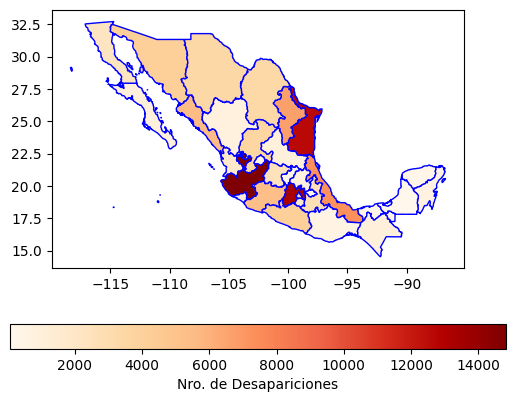

In [ ]:
repo_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json' #Archivo GeoJSON
mx_regions_geo = gpd.read_file(repo_url)

df_agrupado = df_inicial[['HECHOS_ESTADO_NOMBRE','CONSECUTIVO']].groupby('HECHOS_ESTADO_NOMBRE').count().reset_index()
df_agrupado.rename(columns = {'HECHOS_ESTADO_NOMBRE':'name','CONSECUTIVO':'desapariciones'}, inplace = True)

df_agrupado.name = df_agrupado.name.replace({"Coahuila de Zaragoza": "Coahuila", "Michoacán de Ocampo": "Michoacán", "Veracruz de Ignacio de la Llave": "Veracruz"})

merged_df = pd.merge(mx_regions_geo, df_agrupado, how='inner', on='name')

merged_df.plot(column='desapariciones',
               legend=True,
               legend_kwds={"label": "Nro. de Desapariciones", "orientation": "horizontal"},
               cmap='OrRd',
               edgecolor="blue");

#####Nro. de Desapariciones en México según Estado (Mapa Coroplético Dinámico)

In [ ]:
repo_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json' #Archivo GeoJSON
mx_regions_geo = requests.get(repo_url).json()

fig = px.choropleth(data_frame=df_agrupado,
                    geojson=mx_regions_geo,
                    locations='name', # nombre de la columna del Dataframe
                    featureidkey='properties.name',  # ruta al campo del archivo GeoJSON con el que se hará la relación (nombre de los estados)
                    color='desapariciones', #El color depende de las cantidades
                    color_continuous_scale="greens", #greens
                    #scope="north america"
                   )

fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")

fig.update_layout(
    title_text = 'Nro. de Desapariciones en México según Estado',
    font=dict(
        #family="Courier New, monospace",
        family="Ubuntu",
        size=18,
        color="#7f7f7f"
    ),
    annotations = [dict(
        x=0.55,
        y=-0.1,
        xref='paper',
        yref='paper',
        text='Fuente: <a href="https://versionpublicarnpdno.segob.gob.mx/Dashboard/Index">\
            RNPDNO </a>',
        showarrow = False
    )]
)

fig.show()

## ClusterMap (no escalado)

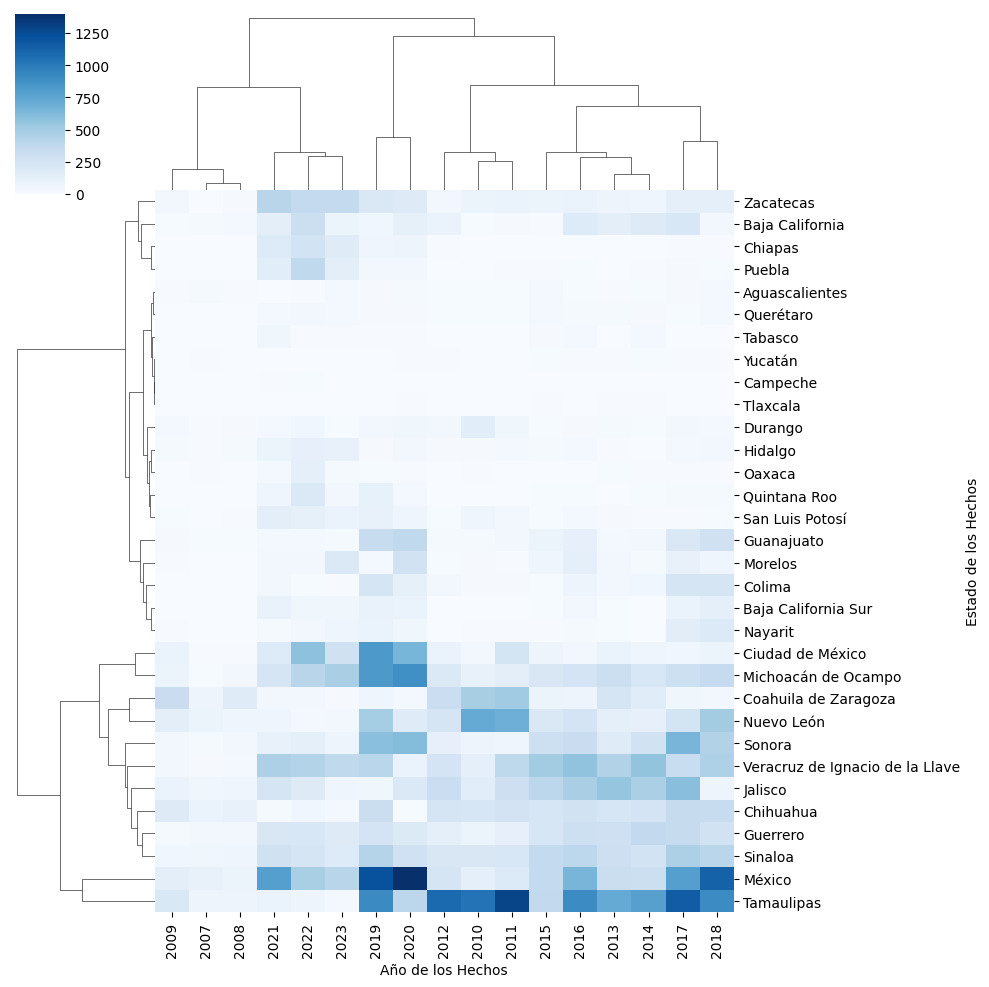

In [ ]:
df_grouped = df_modif.groupby(['HECHOS_ESTADO_NOMBRE','HECHOS_AÑOS']).agg({'CONSECUTIVO': 'count'}).reset_index()
df_filtered = df_grouped[(df_grouped['HECHOS_AÑOS'] >= 2007) & (df_grouped['HECHOS_AÑOS'] <= 2023) & (df_grouped['HECHOS_ESTADO_NOMBRE'].notnull())].reset_index()

table = pd.pivot_table(df_filtered, values = 'CONSECUTIVO',
                       index = 'HECHOS_ESTADO_NOMBRE',
                       columns = 'HECHOS_AÑOS',
                       aggfunc = 'sum').fillna(0).astype('int64')

g = sns.clustermap(table, method="ward", cmap="Blues", figsize=(10,10))
ax = g.ax_heatmap
ax.set_xlabel("Año de los Hechos", fontsize = 10)
ax.set_ylabel("Estado de los Hechos", fontsize = 10)
plt.show()

## ClusterMap (escalado)

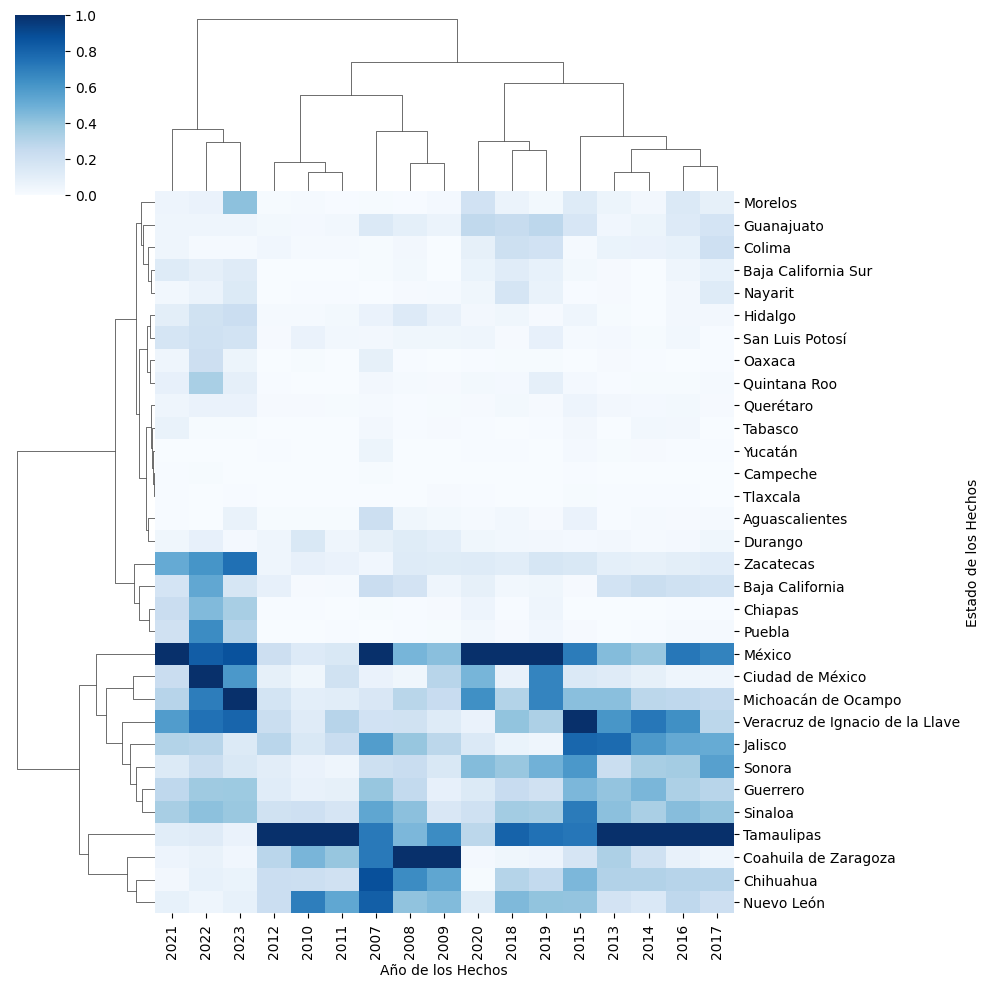

In [ ]:
table = pd.pivot_table(df_filtered, values = 'CONSECUTIVO',
                       index = 'HECHOS_ESTADO_NOMBRE',
                       columns = 'HECHOS_AÑOS',
                       aggfunc = 'sum').fillna(0).astype('int64')

g = sns.clustermap(table, standard_scale=1, method="ward", cmap="Blues", figsize=(10,10))
ax = g.ax_heatmap
ax.set_xlabel("Año de los Hechos", fontsize = 10)
ax.set_ylabel("Estado de los Hechos", fontsize = 10)
plt.show()